# The Numerical Sandbox: Extension Experiment

**Romain Beucher**
Version 0.1

romain.beucher@unimelb.edu.au

The following notebook is an implementation of the Numerical Sandbox Extension Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

The test has been implemented using Fantom in [Thieulot, 2011](http://linkinghub.elsevier.com/retrieve/pii/S0031920111001336) and more recently with Aspect in [Glerum et al., 2017](http://www.solid-earth-discuss.net/se-2017-9). 

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 

Results for the extension experiment after 2cm extension (Buiter et al., 2006)

In [1]:
import os
import numpy as np
import warnings; warnings.simplefilter('ignore')

import underworld as uw
import underworld.function as fn
import glucifer

import unsupported.scaling as sca
from unsupported.geodynamics import *

In [2]:
uw_output_path = 'sandbox3'

if uw.rank() == 0:
    if not os.path.exists(uw_output_path):
        os.makedirs(uw_output_path)

## Scaling

In [3]:
u = sca.UnitRegistry
nd = sca.nonDimensionalize

velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

sca.scaling["[length]"] = KL.to_base_units()
sca.scaling["[time]"] = Kt.to_base_units()
sca.scaling["[mass]"]= KM.to_base_units()

### General parameters

In [4]:
gravity = nd(9.81 * u.meter / u.second**2)

# Model Geometry

Set-up of the extension experiment. A viscous layer (PDMS, 10 x 0.5 cm) lies in the central part of the model on the base. The rest of the model consists of three ‘sand’ layers (only differing in colour). Extension is achieved by moving the right wall with the attached 10 cm long sheet outwards to the right.

<img src="images/Extension.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)

In [5]:
nx = 400
ny = 100

minX = nd(   0. * u.centimeter)
maxX = nd(  20. * u.centimeter)
minY = nd( -3.5 * u.centimeter)
maxY = nd(  1.5 * u.centimeter)

elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType = (elementType),
                                elementRes  = (nx, ny),
                                minCoord    = (minX, minY),
                                maxCoord    = (maxX, maxY),
                                periodic    = (False, False))

#### Particle Swarm

In [6]:
swarm  = uw.swarm.Swarm(mesh = mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm = swarm, particlesPerCell=20)
swarm.populate_using_layout(layout = swarmLayout)

#### Mesh Variables

In [7]:
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=mesh.dim )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
meshStretching = uw.mesh.MeshVariable( mesh, 2 )

velocityField.data[...] = 0.0
pressureField.data[...] = 0.0

#### Swarm Variables

In [8]:
materialIndexField = swarm.add_variable( dataType="int", count=1 )
viscosityField  = swarm.add_variable( dataType="double", count=1)
strainRateVar = swarm.add_variable(dataType="double", count=1)
cumulativeTotalStrain = swarm.add_variable( dataType="double", count=1)

# These ones are for monitoring of the shear bands

stretching = swarm.add_variable( dataType="double", count=mesh.dim)
orientation = swarm.add_variable( dataType="double", count=1)

materialIndexField.data[:] = 0
viscosityField.data[:] = 0.
strainRateVar.data[:] = 0.
orientation.data[:] = 0.

# Stretching - assume an initial orientation aligned with the x-axis
stretching.data[:,0] = 1.0
stretching.data[:,1] = 0.0

cumulativeTotalStrain.data[...] = 0.0

# Visualisation

Underworld2 offers many options for visualisation. In the context of this Jupyter notebook we will use glucifer functions to visualise the progression of our setup and the results of the model.

In [9]:
GluciferStore = glucifer.Store(os.path.join(uw_output_path, "glucifer"))
Dim = sca.Dimensionalize

GluciferFigures = []

projectStretching = uw.utils.MeshVariable_Projection( meshStretching, stretching, type=0 )

FigMaterials = glucifer.Figure(name="Materials", store=GluciferStore, border=False, figsize=(1600,400))
Materials = glucifer.objects.Points(swarm, materialIndexField, pointsize=2, name="Material Points", label="Material", colourBar=True)
FigMaterials.append(Materials)
GluciferFigures.append(FigMaterials)

FigVelocities = glucifer.Figure(name="Velocity", store=GluciferStore, border=False, figsize=(1600,400))
velocities = glucifer.objects.VectorArrows(mesh, Dim(velocityField, u.centimeter / u.year), name="Velocity", scaling=2e-6)
FigVelocities.append(velocities)
FigVelocities.append(Materials)
GluciferFigures.append(FigVelocities)

FigPressure = glucifer.Figure(name="Pressure", store=GluciferStore, border=False, figsize=(1600,400))
pressure = glucifer.objects.Surface(mesh, pressureField, name="Pressure")
FigPressure.append(pressure)
GluciferFigures.append(FigPressure)
    
FigStrainRate = glucifer.Figure(name="Strain Rate", store=GluciferStore, border=False, figsize=(1600,400))
strainR = glucifer.objects.Points(swarm, strainRateVar, pointsize=2, name="Strain Rate", colourBar=True, colours="coolwarm", logScale=True)
FigStrainRate.append(strainR)
GluciferFigures.append(FigStrainRate)

FigViscosity = glucifer.Figure(name="Viscosity", store=GluciferStore, border=False, figsize=(1600,400))
viscosity = glucifer.objects.Points(swarm, viscosityField, pointsize=2, name="Viscosity", colourBar=True, colours="coolwarm", logScale=True) 
FigViscosity.append(viscosity)
GluciferFigures.append(FigViscosity)

FigMeshStretching = glucifer.Figure(name="Mesh Stretching", store=GluciferStore, border=False, figsize=(1600,400))
FigMeshStretching.append( glucifer.objects.VectorArrows(mesh, meshStretching, scaling=0.1, arrowHead=0.00001, resolutionI=100, resolutionJ=25)) 
FigMeshStretching.append( glucifer.objects.Points(swarm, orientation , pointSize=5.0, colours="#448800, #666666:0.0, #0099FF") )
GluciferFigures.append(FigMeshStretching)

def UpdateGluciferFigures(step, figures):
    GluciferStore.step = step
    for figure in figures:
        figure.save()

# Initial Setup

## Material distribution

The way we choose do define the initial set up is based on the distribution of the different materials (or phases).

In [10]:
air = Material()
sand1 = Material()
sand2 = Material()
silicon = Material()

materials = [silicon, air, sand2, sand1]

In [11]:
air.top     = maxY
air.bottom  = nd(0.*u.centimeter)
sand1.top    = nd(0.*u.centimeter)
sand1.bottom = minY
sand2.top = nd(-1. * u.centimeter)
sand2.bottom = nd(-2. * u.centimeter)

for material in materials:
    material.shape = utils.layer(material.top, material.bottom, minX, maxX)

The silicon is defined as a polygon

In [12]:
vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

vertices = np.array([(nd(x), nd(y)) for x,y in vertices])
silicon.shape = uw.function.shape.Polygon(vertices)

All the shapes being defined, we can now assign a material index to each particle in the material swarm:

In [13]:
conditions = [(obj.shape, obj.index) for obj in materials if obj.shape is not None] 
materialIndexField.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


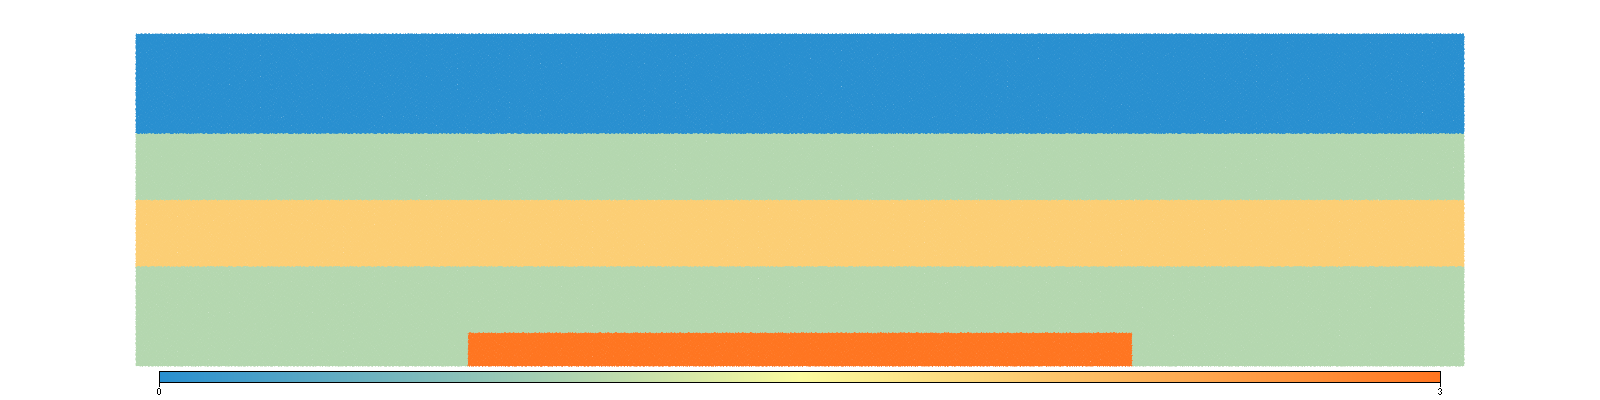

In [14]:
FigMaterials.show()

## Material properties

The swarm is initialialised but we now need to define the physical properties of our materials:

### Densities

In [15]:
air.density = nd(  10. * u.kilogram / u.metre**3)
sand1.density = nd(1560. * u.kilogram / u.metre**3)
sand2.density = nd(1560. * u.kilogram / u.metre**3)
silicon.density = nd( 965. * u.kilogram / u.metre**3)

### Buoyancy Force

Define how the material densities interact with the gravity field.

In [16]:
densityMap = {}
for material in materials:
    densityMap[material.index] = material.density
    
densityFn = fn.branching.map(fn_key=materialIndexField, mapping=densityMap)

z_hat = ( 0.0, -1.0 )
buoyancyFn = densityFn * z_hat * gravity

## Material Rheologies

In [17]:
strainRateFn = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

In [18]:
air.rheology = Rheology()
sand1.rheology = Rheology()
sand2.rheology = Rheology()
silicon.rheology = Rheology()

In [19]:
# Assign function to materials
air.rheology.viscosity     = fn.misc.constant(nd(1.0e2  * u.pascal * u.second))
sand1.rheology.viscosity    = fn.misc.constant(nd(1.0e13 * u.pascal * u.second))
sand2.rheology.viscosity    = fn.misc.constant(nd(1.0e13 * u.pascal * u.second))
silicon.rheology.viscosity = fn.misc.constant(nd(5.0e4  * u.pascal * u.second))

## Plasticity

The material behaviour of the numeric brittle materials is characterised by a Coulomb failure-frictional criterion:
$$\sigma_t = \sigma_n \tan \Phi + C$$

where $\sigma_t$ denotes shear stress, $\sigma_n$ normal stress, $\Phi$ the angle of internal friction and $C$ cohesion.

The softening of the material is simulated by a linear decrease in the angle of internal friction over a finite strain interval of 0.5 to 1.0 (finite strain is total accumulated effective strain as measured by the square root of the second invariant of the strain tensor).

In [20]:
def frictionWeakening(cumulativeTotalStrain, Friction, FrictionSw, epsilon1=0.5, epsilon2=1.0):
    """
    Return the angle of internal friction assuming a linear decrease between the interval
    [epsilon1, epsilon2]
    """
    frictionVal = [(cumulativeTotalStrain < epsilon1, Friction),
                   (cumulativeTotalStrain > epsilon2, FrictionSw),
                   (True, Friction + ((Friction - FrictionSw)/(epsilon1 - epsilon2)) * (cumulativeTotalStrain - epsilon1))]

    frictionVal = fn.branching.conditional(frictionVal)
    
    return frictionVal

In [21]:
sand1.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))
sand1.rheology.friction = frictionWeakening(cumulativeTotalStrain, Friction=np.radians(36.0), FrictionSw=np.radians(31.0))
sand2.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))
sand2.rheology.friction = frictionWeakening(cumulativeTotalStrain, Friction=np.radians(36.0), FrictionSw=np.radians(31.0))

for material in materials:
    rheology = material.rheology
    if rheology.cohesion != None and rheology.friction != None:
        C = rheology.cohesion
        Phi = rheology.friction
        YieldStress = C*fn.math.cos(Phi) + pressureField * fn.math.sin(Phi)
        #YieldStress = C + pressureField * fn.math.tan(Phi)
        rheology.plasticity =  0.5 * YieldStress / strainRate_2ndInvariantFn
    else:
        rheology.plasticity = rheology.viscosity

### Viscosity Limiter / Yielding

In [22]:
min_viscosity = air.rheology.viscosity
max_viscosity = nd(1e9 * u.pascal * u.second)

def viscosityLimiter(viscosityFn):
    maxBound = fn.misc.min(viscosityFn, max_viscosity)
    minMaxBound = fn.misc.max(maxBound, min_viscosity)
    return minMaxBound 
    
ViscosityMap = {}
for material in materials:
    ViscosityMap[material.index] = viscosityLimiter(material.rheology.viscosity)
    if material.rheology.plasticity:
        plasticity = material.rheology.plasticity
        viscosity = material.rheology.viscosity
        ViscosityMap[material.index] = viscosityLimiter(fn.misc.min(plasticity, viscosity))

viscosityFn = fn.branching.map(fn_key = materialIndexField, mapping = ViscosityMap)

BGViscosityMap = {}
for material in materials:
    BGViscosityMap[material.index] = viscosityLimiter(material.rheology.viscosity)

backgroundViscosityFn = fn.branching.map(fn_key = materialIndexField, mapping = BGViscosityMap)


# Yield criterion
SYconditions = [(viscosityFn < backgroundViscosityFn, strainRate_2ndInvariantFn),
                (True, 0.0)]

isYielding = fn.branching.conditional(SYconditions)

# Boundary conditions

+ Basal points above the moving sheet are assigned the velocity of the sheet
+ Basal points to the left of the moving sheet are held fixed. 
+ The change in velocity at the basal velocity discontinuity is accommodated over 0.2 cm. 
+ The vertical sides are fixed.

In [23]:
right = mesh.specialSets["MaxI_VertexSet"]
left = mesh.specialSets["MinI_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

# Define Bottom condition
velocityField.data[...] = 0.0
    
for node in base:
    x, y = mesh.data[node]
    if x > nd(10.1 * u.centimetre):
        velocityField.data[node,0] = nd(velocity)
    elif x > nd(9.9 * u.centimetre):
        velocityField.data[node,0] = (x - nd(9.9 * u.centimetre)) * nd(velocity) / nd(0.2 * u.centimetre)
    
for node in right:
    velocityField.data[node, 0] = nd(velocity)

stokesBC = uw.conditions.DirichletCondition(variable = velocityField, indexSetsPerDof = (right+left+base, base))

# Set-up and solve initial isoviscous model

In [24]:
stokes = uw.systems.Stokes(velocityField = velocityField, 
                           pressureField = pressureField,
                           conditions    = stokesBC,
                           fn_viscosity  = backgroundViscosityFn, 
                           fn_bodyforce  = buoyancyFn)

solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
solver.set_penalty(1.0e6) 
solver.solve()

# Set-up Visco-plastic solve

In [25]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = stokesBC,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn)

solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
solver.set_penalty(1.0e6) 

# Pressure Calibration

In [26]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def smooth_pressure(mesh, pressure):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.
    NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
    Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressure, type=0)
    Nodes2Cell = uw.utils.MeshVariable_Projection(pressure, NodePressure, type=0)
    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh, pressureField)

# Main simulation loop

In [27]:
advector   = uw.systems.SwarmAdvector( swarm = swarm, velocityField=velocityField, order=2 )

population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=True,splitThreshold=0.15, 
                                                maxDeletions=2,maxSplits=10,
                                                particlesPerCell=18)

In [28]:
CFL = 0.5
time = 0.
endTime = nd(0.5 * u.hour)


checkpoint_number = 0
UpdateGluciferFigures(checkpoint_number, GluciferFigures)

while time < endTime:
    
    solver.solve(nonLinearIterate=True, callback_post_solve = pressure_calibrate)
    
    viscosityField.data[:] = viscosityFn.evaluate(swarm)
    strainRateVar.data[:] = strainRate_2ndInvariantFn.evaluate(swarm)
    
    checkpoint_number +=1

    dt = CFL * advector.get_max_dt()
    
    # update plastic strain
    plasticStrainIncrement = dt * isYielding.evaluate(swarm)
    cumulativeTotalStrain.data[:] += plasticStrainIncrement
         
    if uw.rank()==0:   
        print('checkpoint_number = {0:6d}; time = {1:.3e}'.format(checkpoint_number, sca.Dimensionalize(time, u.hours)))
        
    advector.integrate(dt, update_owners=True) 
    population_control.repopulate() 
    
    # update stretching metric
    swarmVgrad = velocityField.fn_gradient.evaluate(swarm)
    stretching.data[:,0] += dt * (swarmVgrad[:,0] * stretching.data[:,0] + swarmVgrad[:,1] * stretching.data[:,1])
    stretching.data[:,1] += dt * (swarmVgrad[:,2] * stretching.data[:,0] + swarmVgrad[:,3] * stretching.data[:,1])
    
    orientation.data[:,0] = np.where( np.abs(swarmVgrad[:,0]) > 1.1, -180 * np.arctan2(stretching.data[:,1] / np.pi, stretching.data[:,0]) / np.pi, 0.0)
    projectStretching.solve()
    meshStretching.data[:,0] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )
    meshStretching.data[:,1] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )

    UpdateGluciferFigures(checkpoint_number, GluciferFigures)
       
    time +=dt

checkpoint_number =      1; time = 0.000e+00 hour
checkpoint_number =      2; time = 4.978e-03 hour
checkpoint_number =      3; time = 9.957e-03 hour
checkpoint_number =      4; time = 1.494e-02 hour
checkpoint_number =      5; time = 1.992e-02 hour
checkpoint_number =      6; time = 2.490e-02 hour
checkpoint_number =      7; time = 2.989e-02 hour
checkpoint_number =      8; time = 3.487e-02 hour
checkpoint_number =      9; time = 3.986e-02 hour
checkpoint_number =     10; time = 4.485e-02 hour
checkpoint_number =     11; time = 4.984e-02 hour
checkpoint_number =     12; time = 5.483e-02 hour
checkpoint_number =     13; time = 5.982e-02 hour
checkpoint_number =     14; time = 6.482e-02 hour
checkpoint_number =     15; time = 6.981e-02 hour
checkpoint_number =     16; time = 7.480e-02 hour
checkpoint_number =     17; time = 7.980e-02 hour
checkpoint_number =     18; time = 8.479e-02 hour
checkpoint_number =     19; time = 8.978e-02 hour
checkpoint_number =     20; time = 9.478e-02 hour



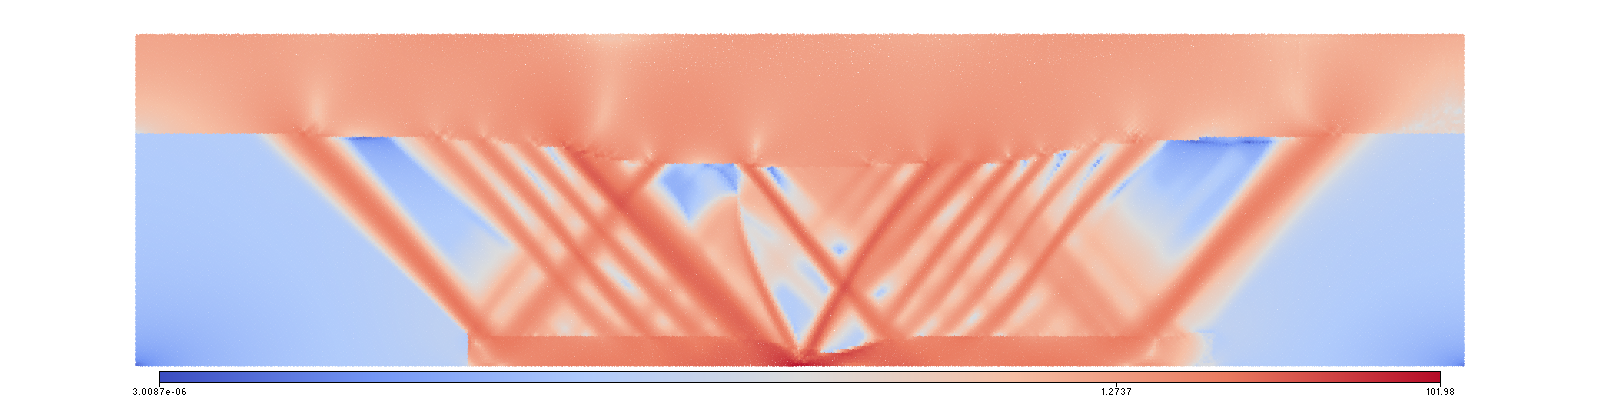

In [29]:
FigStrainRate.show()


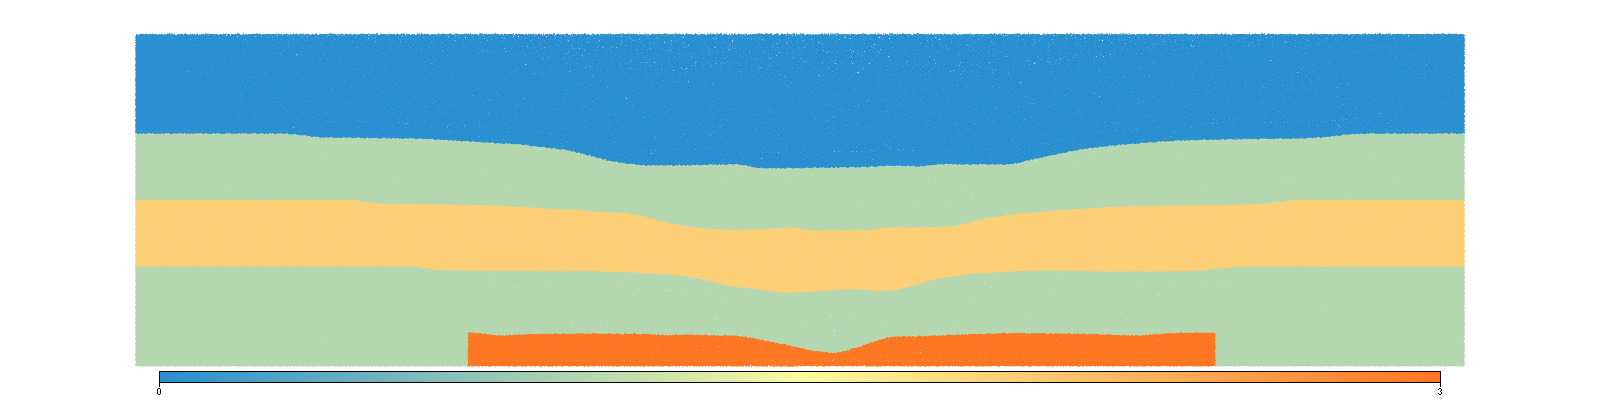

In [30]:
FigVelocities.show()


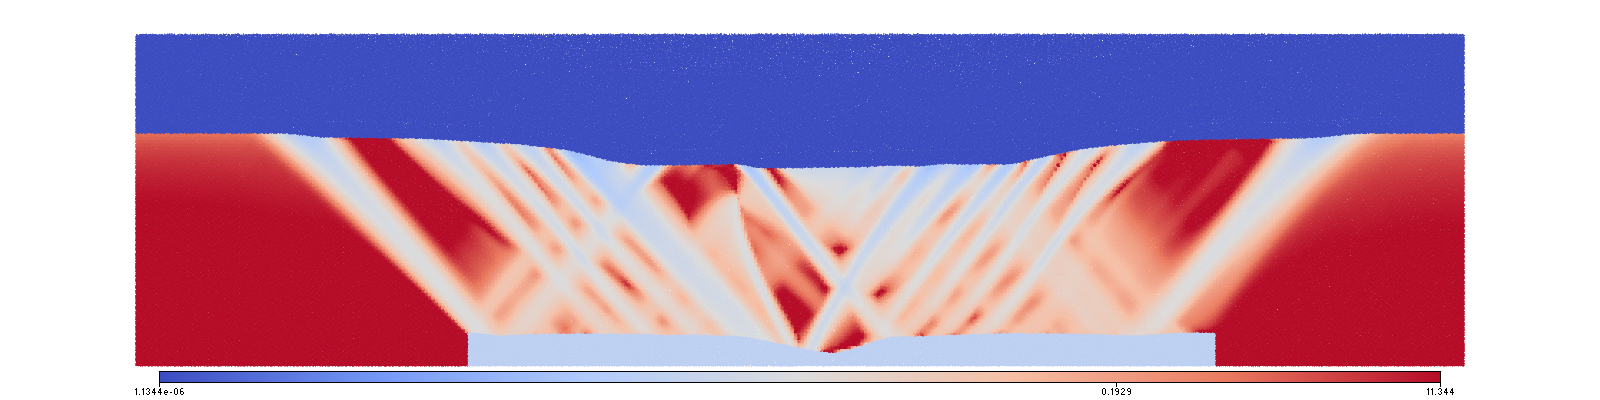

In [31]:
FigViscosity.show()


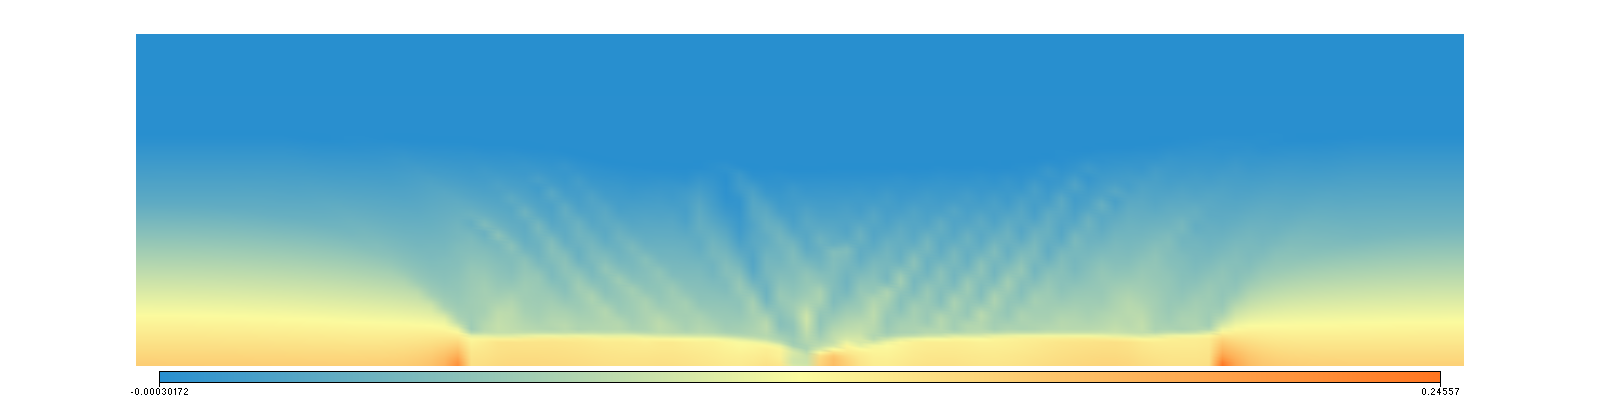

In [32]:
FigPressure.show()


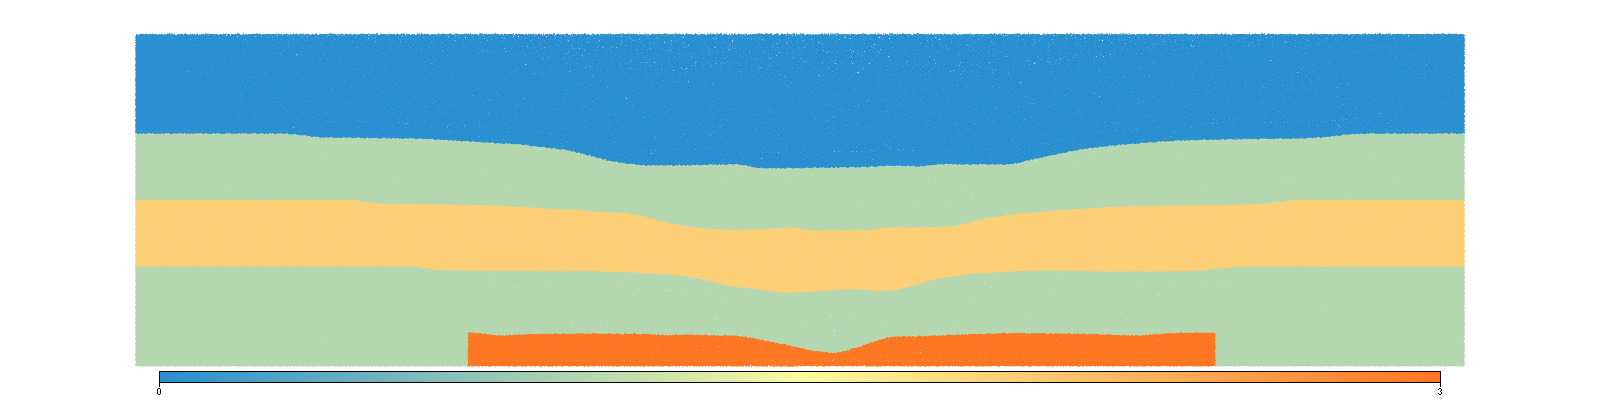

In [33]:
FigMaterials.show()